In [103]:
import sys
sys.path.append("../")

In [104]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF, Linear

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle

import high_dim_power as hd

import matplotlib as mpl
import matplotlib.pyplot as pyplot
mpl.rcParams["mathtext.fontset"] = "cm"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# KSD

In [106]:
tf.random.set_seed(1)

DELTA = 2. # 0.1

BANDWIDTH_POWER = 1.

STATISTIC = "ksd"

KERNEL = RBF

DIR = "../res/high_dim/dist"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"

# Load results

In [107]:
# load analytical res
res_analytical_save = pd.read_csv(
    f"{DIR}/res_analytical_{SUFFIX}.csv",
)
# res_analytical = {c: res_analytical_save[c].to_list() for c in res_analytical_save.columns}
# dims = list(res_analytical["dim"])
res_analytical = res_analytical_save.set_index("dim", drop=False)

In [123]:
# load empirical results
# fixed n
stats_res_list = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}.p", "rb"),
)
dims = list(stats_res_list[0].keys())

# quadratic increasing n
quad_dir = "quad"

stats_res_list_quad = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_{quad_dir}.p", "rb"),
)
dims_quad = list(stats_res_list_quad[0].keys())

# sqrt increasing n
stats_res_list_sqrt = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_sqrt.p", "rb"),
)
dims_sqrt = list(stats_res_list_sqrt[0].keys())

In [124]:
ns = [50] * len(dims)

# ns_quad = [max(2, int(d**1.2)) for d in dims]
ns_quad = [max(2, int(d**2)) for d in dims]

# ns_sqrt = [max(2, int(d**0.5)) for d in dims]
ns_sqrt = [max(2, int(d**0.5)) for d in dims]

# Initialise result classes

In [125]:
# fixed n
d = dims[-1]
print("dim:", d)
ts = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_rep_dims = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns,
    ts=ts,
)

dim: 2000


In [126]:
# quadratic n
d = 100
print("dim:", d)
ts_quad = res_analytical.loc[d, "expectation"] * np.linspace(.96, 1.04, 101)

hd_limits_rep_dims_quad = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_quad,
    res_analytical=res_analytical,
    dims=dims_quad,
    ns=ns_quad,
    ts=ts_quad,
)

dim: 100


In [127]:
# sqrt n
d = dims[-1]
print("dim:", d)
ts_sqrt = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_rep_dims_sqrt = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_sqrt,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns_sqrt,
    ts=ts_sqrt,
)

dim: 2000


## distance

In [128]:
# compute distances
dist_rep = hd_limits_rep_dims.compute_distance(size=100000)

# quadratic n
dist_rep_quad = hd_limits_rep_dims_quad.compute_distance(size=100000)

# sqrt n
dist_rep_sqrt = hd_limits_rep_dims_sqrt.compute_distance(size=100000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


In [129]:
labels = {
    "cond": "Non-degen.", 
    "mm_full": "Degen. Gamma",
#     "mm_chi": "Degen. Chi-square",
}

dist_rep.replace(labels, inplace=True)
dist_rep_quad.replace(labels, inplace=True)
dist_rep_sqrt.replace(labels, inplace=True)

In [130]:
seeds = dist_rep_quad.loc[dist_rep_quad.name.isin(["Degen. Gamma"]), "seed"].unique()
# dist_rep_quad.loc[dist_rep_quad.name.isin(["Non-degen."]), "seed"].unique()

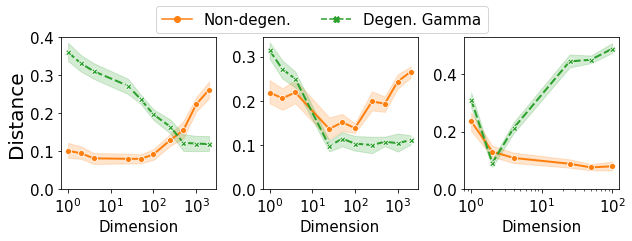

In [131]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2.8))

colors = ["C1", "C2"]

# fixed n
sns.lineplot(
    ax=axes[0],
    data=dist_rep.loc[(dist_rep.name.isin(labels.values())) & (dist_rep.seed.isin(seeds))], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[0].set_xlabel("Dimension", fontsize=15)
axes[0].set_ylabel("Distance", fontsize=20)
axes[0].set_ylim(bottom=0.)
axes[0].set_xscale("log")
axes[0].set_xticks([1, 10, 100, 1000])
axes[0].tick_params(labelsize=15)
axes[0].legend([],[], frameon=False)

# sqrt n
sns.lineplot(
    ax=axes[1],
    data=dist_rep_sqrt.loc[dist_rep_sqrt.name.isin(labels.values())], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[1].set_xlabel("Dimension", fontsize=15)
axes[1].set_ylabel("")
axes[1].set_ylim(bottom=0.)
axes[1].set_xscale("log")
axes[1].set_xticks([1, 10, 100, 1000])
axes[1].tick_params(labelsize=15)
axes[1].legend([],[], frameon=False)

# quad n
sns.lineplot(
    ax=axes[2],
    data=dist_rep_quad.loc[dist_rep_quad.name.isin(labels.values())], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
    palette=colors,
)

axes[2].set_xlabel("Dimension", fontsize=15)
axes[2].set_ylabel("")
axes[2].set_ylim(bottom=0.)
axes[2].set_xscale("log")
axes[2].tick_params(labelsize=15)
axes[2].legend([],[], frameon=False)
axes[2].set_xticks([1, 10, 100])

axes[0].legend(
    fontsize=15, bbox_to_anchor=(2.8, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

plt.subplots_adjust(
    wspace=0.3,
)
plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}_ns_dims.pdf", bbox_inches="tight")

In [132]:
dist_rep_quad.loc[dist_rep_quad.name.isin(labels.values())].seed.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Debug

In [88]:
d = 100

In [89]:
# compute CDFs
cdf_rep_quad = hd_limits_rep_dims_quad.run(dim=d)
# cdf_rep_quad.replace(legend, inplace=True)

In [90]:
# pdf
samples_res_quad = hd_limits_rep_dims_quad.get_exp(d).sample_all_limits(size=1000)
# `samples_res_quad.replace(legend, inplace=True)

In [91]:
np.mean(hd_limits_rep_dims_quad.empirical_vals_dims_list[0][d])

1.4853727

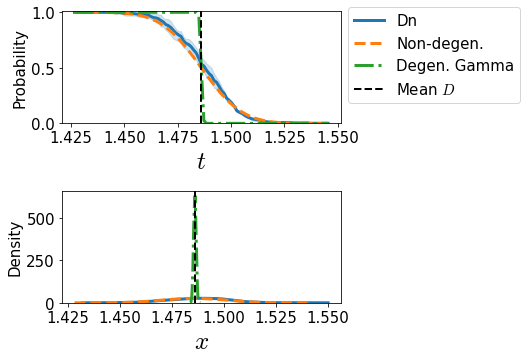

In [92]:
legend_labels = {
    "probs": "Dn", 
    "cond": "Non-degen.", 
#     "full": "High dim Gaussian",
    "mm_full": "Degen. Gamma",
#     "mm_chi": "High dim Chi-square",
}

linestyles = ["solid", "dashed", "dashdot", "dotted"]
lw = 3

figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))

ax0 = axes[0]
for i, (n, l) in enumerate(legend_labels.items()):
    sns.lineplot(
        ax=ax0,
        data=cdf_rep_quad.loc[cdf_rep_quad.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )

# statistic expectation
ax0.axvline(
    res_analytical.loc[d, "expectation"], color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

ax0.set_xlabel("$t$", fontsize=25)
ax0.set_ylabel("Probability", fontsize=15)
ax0.set_ylim(0., 1.01)
ax0.tick_params(labelsize=15)
ax0.legend([],[], frameon=False)

# pdf
ax1 = axes[1]
for i, (n, l) in enumerate(legend_labels.items()):
    sns.kdeplot(
        ax=ax1,
        data=samples_res_quad.loc[samples_res_quad.name == n],
        x="x",
        linewidth=lw,
        common_norm=False,
        label=l,
        linestyle=linestyles[i],
        legend=False,
    )
# statistic expectation
ax1.axvline(
    res_analytical.loc[d, "expectation"], color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)
ax1.set_xlabel("$x$", fontsize=25)
ax1.set_ylabel("Density", fontsize=15)
ax1.set_ylim(bottom=0.)
ax1.tick_params(labelsize=15)
# ax1.set_xlim([1.85, 2.15])

ax0.legend(
#     cdf_legends_show,
    fontsize=15, bbox_to_anchor=(1., 1.1), 
)

plt.subplots_adjust(
    top=0.8,
    wspace=0.1,
    hspace=0.6,
)


In [93]:
np.mean(hd_limits_rep_dims_quad.empirical_vals_dims_list[0][d])

1.4853727

In [94]:
import high_dim.analytical as hd_ana

In [95]:
hd_ana.KSDAnalytical(dim=d, mu_norm=DELTA, bandwidth_power=BANDWIDTH_POWER).mean()

1.4861115285078441

# MMD

In [33]:
tf.random.set_seed(1)

DELTA = 2.

BANDWIDTH_POWER = 1.

STATISTIC = "mmd"

KERNEL = RBF 

DIR = "../res/high_dim"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"

In [34]:
dims = [2, 4, 25, 50, 100]

ns_sqrt = [2 * int(d**0.5) for d in dims]

ns_linear = [2 * int(d) for d in dims]

ns_quad = [2 * int(d**1.2) for d in dims]

ns_cube = [2 * int(d**2.2) for d in dims]

In [35]:
# load analytical res
res_analytical_save = pd.read_csv(
    f"{DIR}/res_analytical_{SUFFIX}.csv",
)
# res_analytical = {c: res_analytical_save[c].to_list() for c in res_analytical_save.columns}
# dims = list(res_analytical["dim"])
res_analytical = res_analytical_save.set_index("dim", drop=False)

In [36]:
# load empirical results
# fixed n

# sqrt increasing n
stats_res_list_sqrt = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_sqrt_ld.p", "rb"),
)

# linear increasing n
stats_res_list_linear = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_linear_ld.p", "rb"),
)

# quadratic increasing n
stats_res_list_quad = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_quad_ld.p", "rb"),
)

# cubic increasing n
stats_res_list_cube = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_cub_ld.p", "rb"),
)


## Initialise result classes

In [37]:
# sqrt
d = dims[-1]
print("dim:", d)
ts_sqrt = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_sqrt = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_sqrt,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns_sqrt,
    ts=ts_sqrt,
)

dim: 100


In [38]:
# linear
d = dims[-1]
print("dim:", d)
ts_linear = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_linear = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_linear,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns_linear,
    ts=ts_linear,
)

dim: 100


In [39]:
# quad
d = dims[-1]
print("dim:", d)
ts_quad = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_quad = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_quad,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns_quad,
    ts=ts_quad,
)

dim: 100


In [40]:
# cubic
d = dims[-1]
print("dim:", d)
ts_cube = res_analytical.loc[d, "expectation"] * np.linspace(.25, 1.75, 101)

hd_limits_cube = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_cube,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns_cube,
    ts=ts_cube,
)

dim: 100


## Distance

In [41]:
legend_dict = {
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}

In [42]:
# compute distances
# sqrt n
dist_rep_sqrt = hd_limits_sqrt.compute_distance(size=100000)
dist_rep_sqrt.replace(legend_dict, inplace=True)

# linear n
dist_rep_linear = hd_limits_linear.compute_distance(size=100000)
dist_rep_linear.replace(legend_dict, inplace=True)

# quadratic n
dist_rep_quad = hd_limits_quad.compute_distance(size=100000)
dist_rep_quad.replace(legend_dict, inplace=True)

# cubic n
dist_rep_cube = hd_limits_cube.compute_distance(size=100000)
dist_rep_cube.replace(legend_dict, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


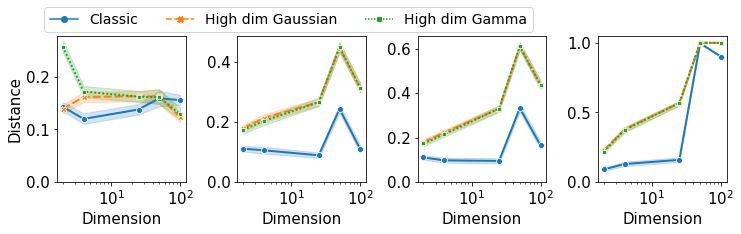

In [44]:
figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

name_list = ["Classic", "High dim Gamma", "High dim Gaussian"]

# sqrt n
sns.lineplot(
    ax=axes[0],
    data=dist_rep_sqrt.loc[(dist_rep_sqrt.name.isin(name_list))], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
)

axes[0].set_xlabel("Dimension", fontsize=15)
axes[0].set_ylabel("Distance", fontsize=15)
axes[0].set_ylim(bottom=0.)
axes[0].set_xscale("log")
axes[0].tick_params(labelsize=15)
axes[0].legend([],[], frameon=False)
axes[0].legend(
    fontsize=14, bbox_to_anchor=(3.75, 1.25), ncol=4, #columnspacing=0.7, handletextpad=0.01
)

# linear n
sns.lineplot(
    ax=axes[1],
    data=dist_rep_linear.loc[dist_rep_linear.name.isin(name_list)], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
)

axes[1].set_xlabel("Dimension", fontsize=15)
axes[1].set_ylabel("")
axes[1].set_ylim(bottom=0.)
axes[1].set_xscale("log")
axes[1].tick_params(labelsize=15)
axes[1].legend([],[], frameon=False)

# quad n
sns.lineplot(
    ax=axes[2],
    data=dist_rep_quad.loc[dist_rep_quad.name.isin(name_list)], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
)

axes[2].set_xlabel("Dimension", fontsize=15)
axes[2].set_ylabel("")
axes[2].set_ylim(bottom=0.)
axes[2].set_xscale("log")
axes[2].tick_params(labelsize=15)
axes[2].legend([],[], frameon=False)

# cubic n
sns.lineplot(
    ax=axes[3],
    data=dist_rep_cube.loc[dist_rep_cube.name.isin(name_list)], 
    x="dim", 
    y="dist", 
    hue="name",
    style="name",
    linewidth=2,
    markers=True,
)

axes[3].set_xlabel("Dimension", fontsize=15)
axes[3].set_ylabel("")
axes[3].set_ylim(bottom=0.)
axes[3].set_xscale("log")
axes[3].tick_params(labelsize=15)
axes[3].legend([],[], frameon=False)

plt.subplots_adjust(
    top=.8,
    wspace=0.4,
)
# plt.savefig(f"../figs/high_dim/dist_{STATISTIC}_{KERNEL.__name__}_ns_dims.pdf", bbox_inches="tight")